This notebook uses a YOLOv8 model ('yolov8m.pt') to predict on test data containing pictures of Pinot Noir vines. It was trained on the data located in /kaggle/input/pinotnoirgrapes/SpltImagesTrain for 35 epochs using the default hyperparamaters and augmentations.

Our data is formatted into one data folder with three sub folders (train, val, test) each containing a sub folder images and labels. The YAML file required for trainig is in the data folder (datafolder/yamlfile). 

I had issues training the model using kaggle notebook, look here (link pending to github) for training notebook.
 
link to [ultralytics](https://github.com/ultralytics/ultralytics)

To run in Colab download this notebook and download the dataset. To download the dataset directly to Colab, much faster, follow the instructions in this video: 
https://www.youtube.com/watch?v=yEXkEUqK52Q&t=65s&ab_channel=DigitalSreeni

In [1]:
!pip install ultralytics --quiet

#vis utils
#from roboflow
##https://github.com/roboflow/supervision
!pip install supervision --quiet

In [2]:
from ultralytics import YOLO
import supervision as sv
import cv2

WARNING  user config directory is not writeable, defaulting to '/tmp/Ultralytics'.


In [3]:
import os 
#where our train/val/test folders reside
data_dir = "/kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir"
out = "/kaggle/working/"
DIRS = {
    'DATA' :  data_dir,
    'OUT': out,
}

PATHS = {
    'TRAINED_MODEL': "/kaggle/input/pinotnoirgrapes/Grapes/Grapes/models/yolov8/single_box_grape/weights/best.pt",
    'TEST_IMG': "/kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test/images/IMG_0203_0.jpg",
    'YAML': '/kaggle/input/pinotnoirgrapes/data.yaml',
}


In [4]:
#loading in model
model=YOLO(PATHS['TRAINED_MODEL'])

In [5]:
#predicting
#pred docs: https://docs.ultralytics.com/modes/predict/#arguments
result = model.predict(source=PATHS['TEST_IMG'], save=True, conf=.25, iou=.25)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
#loading image as array
#load a custom img from the testset
img="path/to/image"
img = cv2.imread(PATHS['TEST_IMG'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#we put our result in our detection class
detections = sv.Detections.from_yolov8(result[0])

#bbox format for plotting
box_annotator = sv.BoxAnnotator(
        thickness=2,
        text_thickness=1,
        text_scale=0.5
    )

#extracting label info
labels = [f"{model.model.names[class_id]} {conf:0.2f}" for _,_, conf, class_id,_ in detections]

#adding the label info and boxes to the img
img = box_annotator.annotate(
    scene=img, 
    detections=detections,
    labels=labels
)

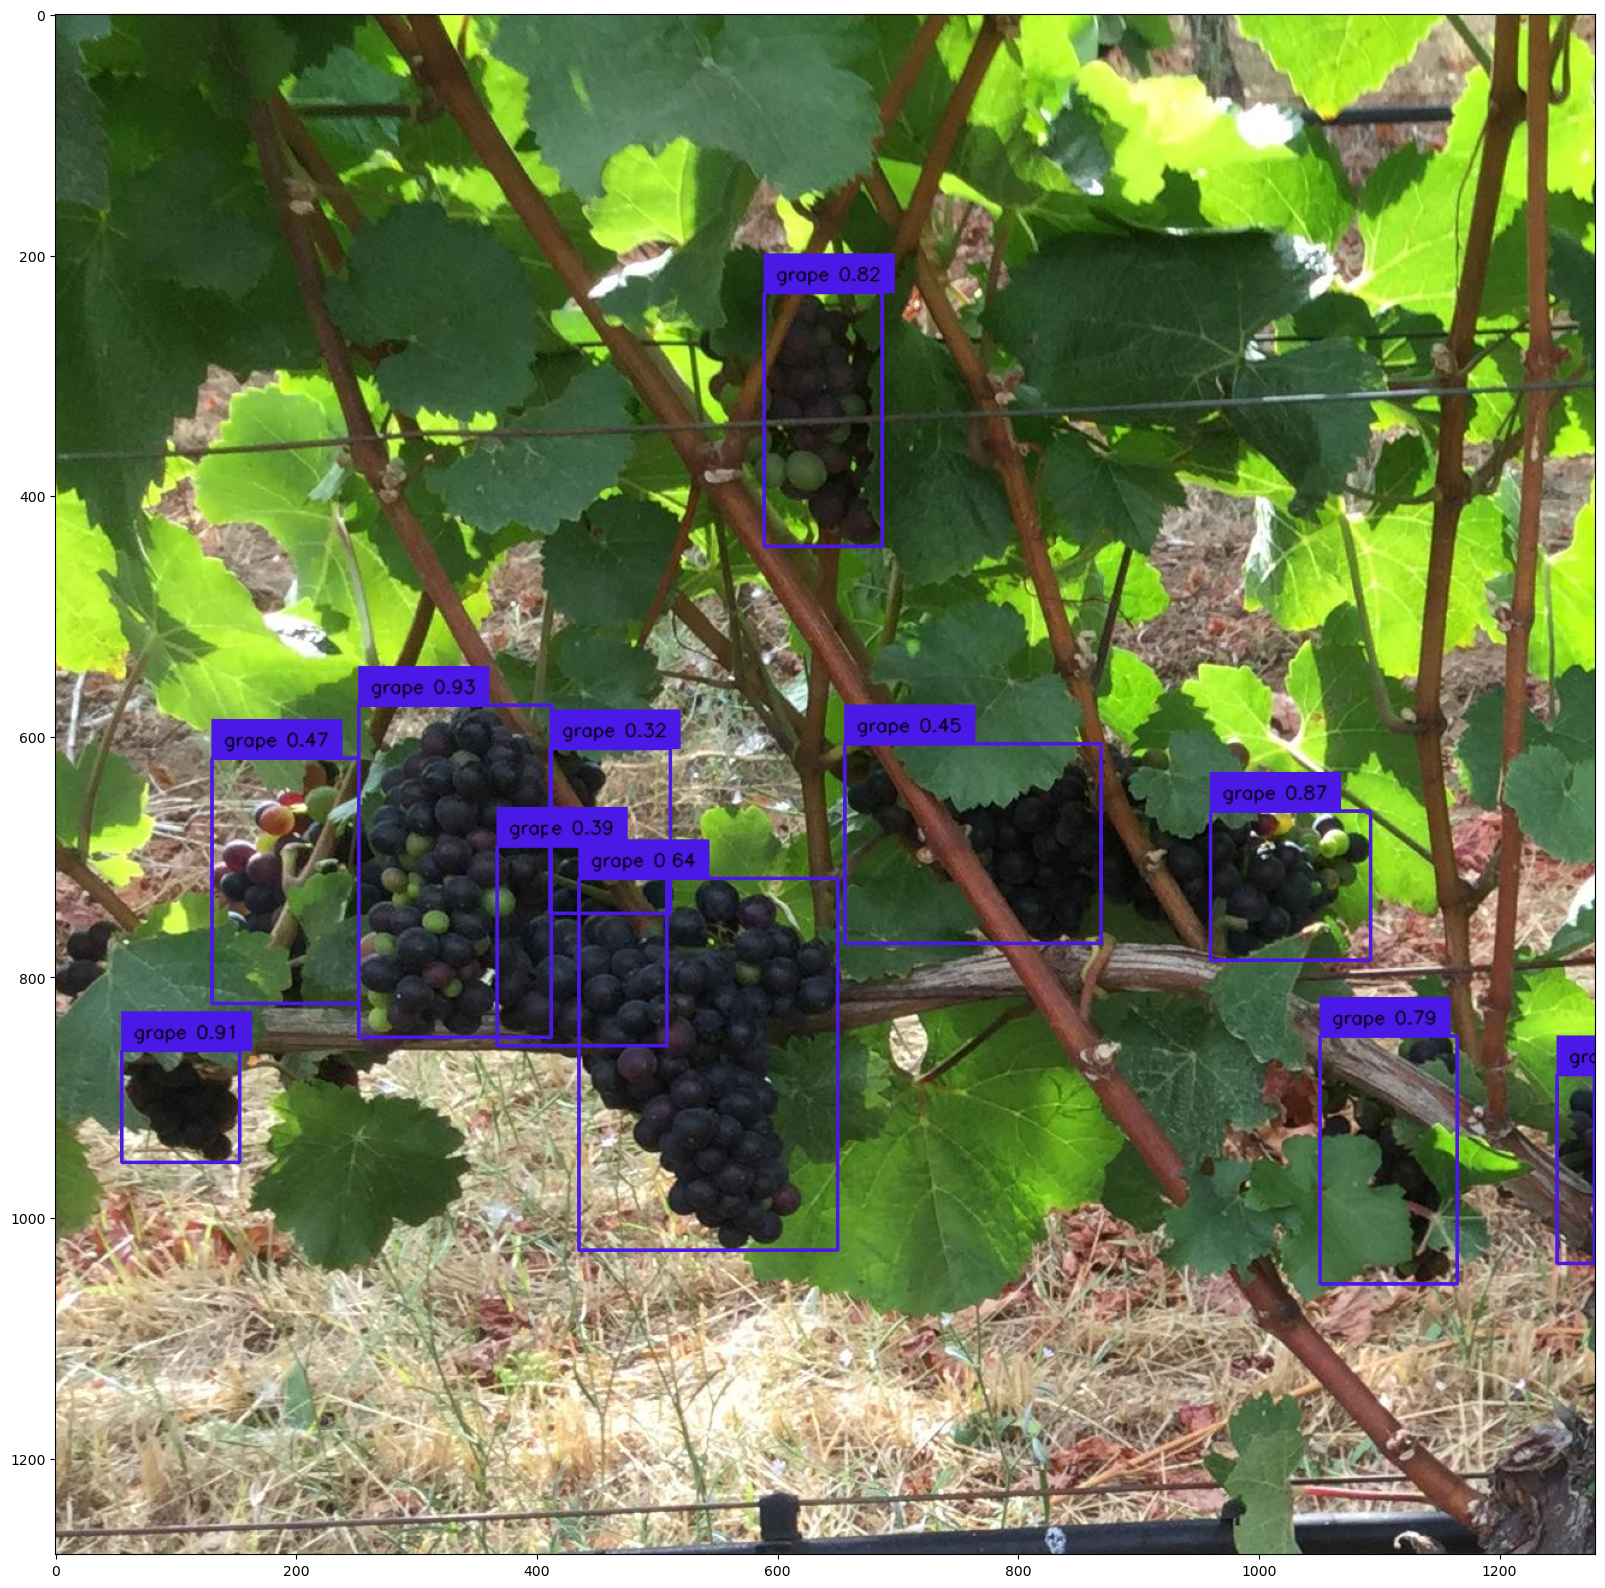

In [7]:
from matplotlib import pyplot as plt
#plotting our pred
plt.figure(figsize = (20,20))
plt.imshow(img)

In [8]:
def pred_on_image_folder(model, image_folder):
  img_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
  for img in img_paths :
    _= model.predict(source=img, save=True, conf=.25, iou=.2)

In [9]:
#loads in images in test dir saves preds to DIRS['OUT']/runs/predict
test_dir = os.path.join(DIRS['DATA'], 'test', 'images')
pred_on_image_folder(model, test_dir )


image 1/1 /kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test/images/IMG_0203_0.jpg: 640x640 11 grapes, 37.0ms
Speed: 2.6ms preprocess, 37.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

image 1/1 /kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test/images/IMG_0238_1.jpg: 448x640 7 grapes, 76.1ms
Speed: 2.4ms preprocess, 76.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

image 1/1 /kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test/images/IMG_0235_0.jpg: 640x640 11 grapes, 37.7ms
Speed: 2.3ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

image 1/1 /kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test/images/IMG_0240_0.jpg: 640x640 9 grapes, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detec

In [10]:
#making dataset
import supervision as sv
image_folder= os.path.join(DIRS['DATA'], 'test/images')
ann_folder=os.path.join(DIRS['DATA'],"test/labels")
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=image_folder,
    annotations_directory_path=ann_folder,
    data_yaml_path=PATHS['YAML'],
    force_masks=False
)

In [11]:
#storing our predictions in the dataset
my_model = YOLO(PATHS['TRAINED_MODEL'])
CONFIDENCE_TRESHOLD = 0.5
IOU=.2
predictions = {}

for image_name, image in ds.images.items():
  image_path = os.path.join(image_folder, image_name)
  result = list(my_model.predict(source=image_path, conf=CONFIDENCE_TRESHOLD, iou=IOU))[0]
  detections = sv.Detections(
      xyxy=result.boxes.xyxy.cpu().numpy(),
      confidence=result.boxes.conf.cpu().numpy(),
      class_id=result.boxes.cls.cpu().numpy().astype(int)
  )
  predictions[image_name] = detections
print(len(predictions))


image 1/1 /kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test/images/IMG_0230_1.jpg: 480x640 8 grapes, 28.7ms
Speed: 2.3ms preprocess, 28.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test/images/IMG_0238_1.jpg: 448x640 5 grapes, 28.5ms
Speed: 2.1ms preprocess, 28.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test/images/IMG_0243_1.jpg: 448x640 9 grapes, 27.7ms
Speed: 2.3ms preprocess, 27.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test/images/IMG_0209_0.jpg: 640x640 8 grapes, 35.3ms
Speed: 2.9ms preprocess, 35.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test/images/IMG_0241_0.jpg: 640x640 7 grapes, 34.6ms
Speed: 2.3ms preproces

10


10


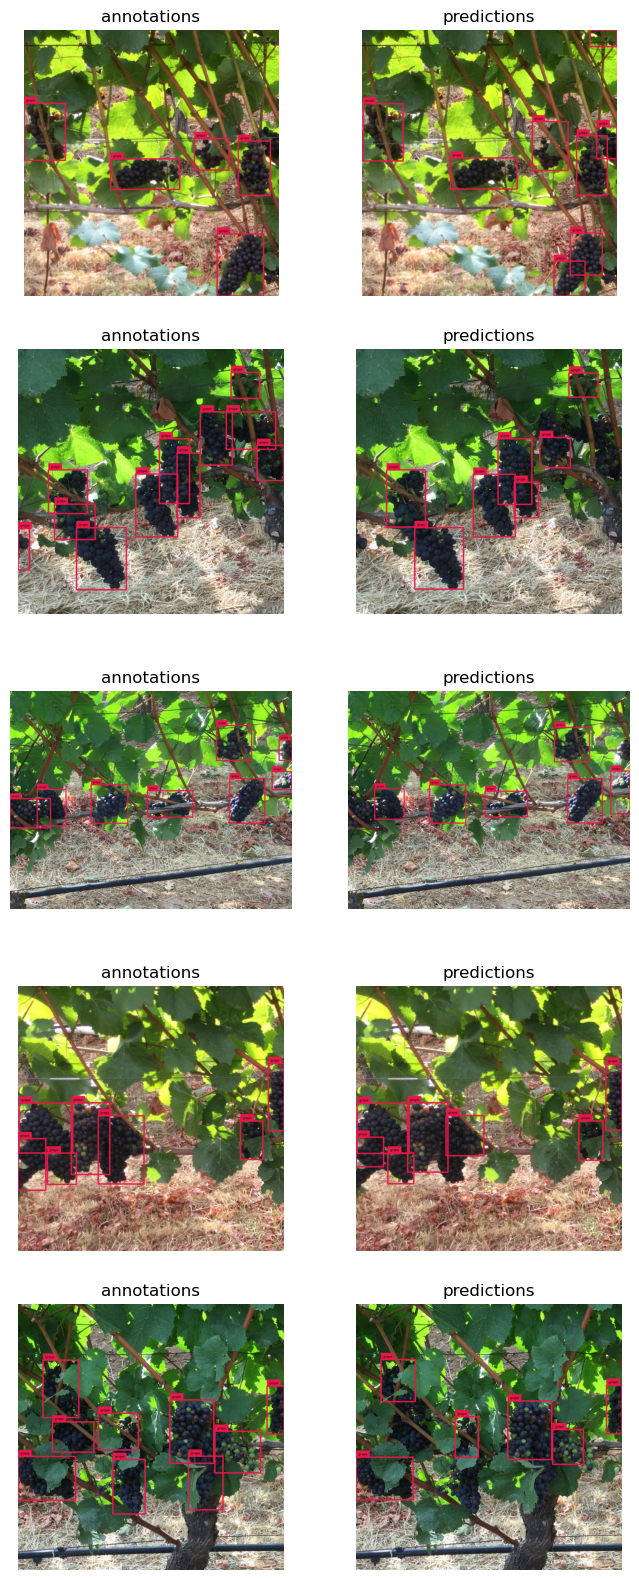

In [12]:
import random
MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator(thickness=5)

images = []
titles = []
id_to_label = {0:'grape'}

for key in keys:
    current_ann=ds.annotations[key]
    gt_labels = [id_to_label[id] for id in current_ann.class_id]
    
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=current_ann,
        labels=gt_labels
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    current_pred = predictions[key]
    pred_labels=[id_to_label[id] for id in current_pred.class_id]
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections= current_pred,
        labels=pred_labels
    )
    images.append(frame_with_predictions)
    titles.append('predictions')
print(len(images))
%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))